# Corrective RAG (CRAG)

Corrective-RAG (CRAG) is a strategy for RAG that incorporates self-reflection / self-grading on retrieved documents. 

In the paper [here](https://arxiv.org/pdf/2401.15884.pdf), a few steps are taken:

* If at least one document exceeds the threshold for relevance, then it proceeds to generation
* Before generation, it performs knowledge refinement
* This partitions the document into "knowledge strips"
* It grades each strip, and filters our irrelevant ones
* If all documents fall below the relevance threshold or if the grader is unsure, then the framework seeks an additional datasource
* It will use web search to supplement retrieval
 
We will implement some of these ideas from scratch using [LangGraph](https://langchain-ai.github.io/langgraph/):

* Let's skip the knowledge refinement phase as a first pass. This can be added back as a node, if desired. 
* If *any* documents are irrelevant, let's opt to supplement retrieval with web search. 
* We'll use [Tavily Search](https://python.langchain.com/v0.2/docs/integrations/tools/tavily_search/) for web search.
* Let's use query re-writing to optimize the query for web search.

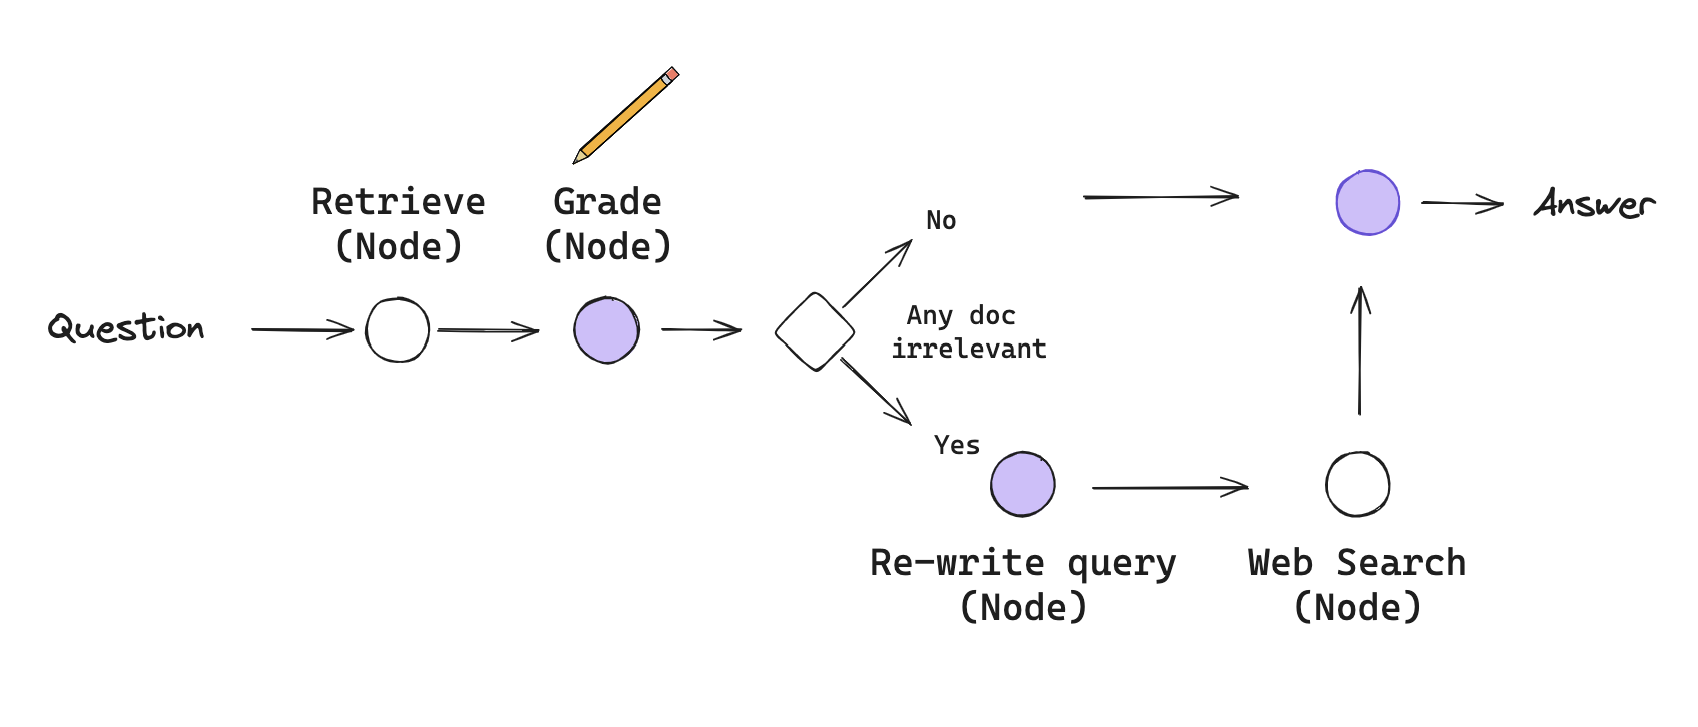

# Environment 

In [1]:
! pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain langgraph tavily-python langchain-aws

### LLMs

In [1]:
import os

os.environ["OPENAI_API_KEY"] = ""

### Search
 
We'll use [Tavily Search](https://python.langchain.com/docs/integrations/tools/tavily_search) for web search.

### Tracing

Optionally, use [LangSmith](https://docs.smith.langchain.com/) for tracing (shown at bottom) by setting

In [2]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = ""

## Index
 
Let's index 3 blog posts.

In [5]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

'''urls = [
    "https://aws.plainenglish.io/rag-solution-using-amazon-bedrock-part-1-build-theamazon-opensearch-serverless-vector-db-using-1656663a302b",
    "https://aws.plainenglish.io/rag-solution-using-amazon-bedrock-part-2-build-the-mcq-orchestrator-using-bedrock-converse-api-61c2b2ce3f20"
]'''

urls = [
    "https://aws.amazon.com/what-is/retrieval-augmented-generation/",
    "https://aws.amazon.com/what-is/artificial-intelligence/",
    "https://aws.amazon.com/what-is/prompt-engineering/",
    "https://aws.amazon.com/what-is/generative-ai/",
    "https://aws.amazon.com/what-is/conversational-ai/",
    "https://aws.amazon.com/what-is/langchain/"
    "https://aws.amazon.com/what-is/gan/",
    "https://aws.amazon.com/what-is/stable-diffusion/",
    "https://aws.amazon.com/what-is/large-language-model/",
    "https://aws.amazon.com/what-is/foundation-models/",
    "https://aws.amazon.com/what-is/gpt/",
    "https://aws.amazon.com/bedrock/pricing/"

]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever()

USER_AGENT environment variable not set, consider setting it to identify your requests.


## LLMs

In [6]:
### Retrieval Grader

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI


# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "agent memory"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


binary_score='no'


In [7]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

I don't know.


In [8]:
### Question Re-writer

# LLM
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'What is the role of memory in artificial intelligence agents?'

## Web Search Tool

In [9]:
### Search

#from langchain_community.tools.tavily_search import TavilySearchResults

#web_search_tool = TavilySearchResults(k=3)

# Graph 

Capture the flow in as a graph.

## Graph state

In [10]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]

In [11]:
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

'''
def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents, "question": question}
'''

### Edges


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    web_search = state["web_search"]
    state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

## Build Graph

The just follows the flow we outlined in the figure above.

In [12]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

#workflow.add_node("web_search_node", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "grade_documents") # udpated to loop back to grade documents and avoid Web Search
#workflow.add_edge("grade_documents", "generate")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

In [37]:
from pprint import pprint

# Run
inputs = {"question": "What is bedrock pricing"}
for output in app.stream(inputs):
    #print(output)
    '''for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")'''
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
('Bedrock pricing refers to the pricing models offered by Amazon Bedrock for '
 'model inference and customization. There are two pricing plans available: '
 'On-Demand and Batch, and Provisioned Throughput. Pricing is dependent on the '
 'modality, provider, and model used.')


In [14]:
from pprint import pprint

# Run
inputs = {"question": "How doesWell-Architected Machine Learning Lens work?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
('The Well-Architected Machine Learning Lens provides guidance on designing '
 'and implementing machine learning workloads on AWS. It focuses on best '
 'practices for building secure, high-performing, resilient, and efficient '
 'machine learning solutions. Key features include recommendations for data '
 'collection, model training, deployment, and monitoring in the cloud.')


LangSmith Traces - 
 
* https://smith.langchain.com/public/f6b1716c-e842-4282-9112-1026b93e246b/r

* https://smith.langchain.com/public/497c8ed9-d9e2-429e-8ada-e64de3ec26c9/r

In [15]:
!pip install llama-index docutils python-dotenv

In [16]:
!pip install giskard[llm]

In [17]:
!pip install giskard

In [18]:
import os
from dotenv import load_dotenv
import boto3
load_dotenv()

False

In [19]:
os.environ["TF_ENABLE_ONEDNN_OPTS"]="0"

In [20]:
import giskard

from giskard.llm.client.bedrock import ClaudeBedrockClient
from giskard.llm.embeddings.bedrock import BedrockEmbedding
from giskard.llm.embeddings import set_default_embedding

bedrock_runtime = boto3.client("bedrock-runtime", region_name="us-east-1")
claude_client = ClaudeBedrockClient(bedrock_runtime, model="anthropic.claude-3-haiku-20240307-v1:0")
embed_client = BedrockEmbedding(bedrock_runtime, model="amazon.titan-embed-text-v1")
giskard.llm.set_default_client(claude_client)
set_default_embedding(embed_client)

import giskard
from giskard.llm.client.bedrock import ClaudeBedrockClient
from giskard.llm.embeddings.bedrock import BedrockEmbedding
from giskard.llm.embeddings import set_default_embedding

bedrock_runtime = boto3.client("bedrock-runtime", region_name="us-east-1")
claude_client = ClaudeBedrockClient(bedrock_runtime, model="anthropic.claude-3-haiku-20240307-v1:0")
embed_client = BedrockEmbedding(bedrock_runtime, model="amazon.titan-embed-text-v1")
giskard.llm.set_default_client(claude_client)
set_default_embedding(embed_client)

In [21]:
import pandas as pd

df = pd.DataFrame([d.page_content for d in doc_splits], columns=["text"])
df.head(10)

,text
0,What is RAG? - Retrieval-Augmented Generation ...
1,Tiếng Việt\nTürkçe\nΡусский\nไทย\n日本語\n한국어\n中文...
2,Products \n Solutions \n Pricing \n Intr...
3,Check out Artificial Intelligence Services \n ...
4,What is Retrieval-Augmented Generation?\nWhy i...
5,LLMs are a key artificial intelligence (AI) te...
6,You can think of the Large Language Model as a...
7,RAG technology brings several benefits to an o...
8,RAG allows the LLM to present accurate informa...
9,How does Retrieval-Augmented Generation work?


In [22]:
from giskard.rag import KnowledgeBase

knowledge_base = KnowledgeBase(df)

2024-09-02 00:34:34.826871: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-02 00:34:36.158289: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [26]:
from giskard.rag import generate_testset
from giskard.rag.question_generators import complex_questions, double_questions
import json,sys

testset = generate_testset(
    knowledge_base,
    num_questions=50,
    agent_description="A chatbot answering questions about the Amazon Bedrock User Guide"
)

Generating questions:   0%|          | 0/50 [00:00<?, ?it/s]

2024-09-02 00:37:00,666 pid:27629 MainThread giskard.rag  ERROR    Encountered error in question generation: Expecting value: line 1 column 1 (char 0). Skipping.
2024-09-02 00:37:00,667 pid:27629 MainThread giskard.rag  ERROR    Expecting value: line 1 column 1 (char 0)
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/giskard/rag/question_generators/base.py", line 57, in generate_questions
    yield self.generate_single_question(knowledge_base, *args, **kwargs)
  File "/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/giskard/rag/question_generators/simple_questions.py", line 96, in generate_single_question
    generated_qa = self._llm_complete(messages=messages)
  File "/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/giskard/rag/question_generators/base.py", line 48, in _llm_complete
    return parse_json_output(out.content, self._llm_client, caller_id=self.__cla

In [27]:
test_set_df = testset.to_pandas()

for index, row in enumerate(test_set_df.head(3).iterrows()):
    print(f"Question {index + 1}: {row[1]['question']}")
    print(f"Reference answer: {row[1]['reference_answer']}")
    print("Reference context:")
    print(row[1]['reference_context'])
    print("******************", end="\n\n")

Question 1: What is the maximum number of tokens that can be used in a text prompt for Stable Diffusion?
Reference answer: You can use up to 75 tokens in a prompt.
Reference context:
Document 153: The most common form of conditioning is text prompts. A CLIP tokenizer analyzes each word in a textual prompt and embeds this data into a 768-value vector. You can use up to 75 tokens in a prompt. Stable Diffusion feeds these prompts from the text encoder to the U-Net noise predictor using a text transformer. By setting the seed to a random number generator, you can generate different images in the latent space.
******************

Question 2: What types of Generative AI services does AWS offer?
Reference answer: AWS offers the most comprehensive set of Generative AI services to help customers innovate faster.
Reference context:
Document 53: Innovate faster with the most comprehensive set of Generative AI services 
            











             Browse Generative AI Trainings 
         

In [28]:
testset.save("test-set.jsonl")

In [29]:
from langchain.prompts import PromptTemplate

template = """
Answer the question based on the context below. If you can't 
answer the question, reply "I don't know".

Context: {context}

Question: {question}
"""

prompt = PromptTemplate.from_template(template)
print(prompt.format(context="Here is some context", question="Here is a question"))


Answer the question based on the context below. If you can't 
answer the question, reply "I don't know".

Context: Here is some context

Question: Here is a question



In [30]:
!pip install ragas  -qU

In [42]:
pprint(value["generation"])

('Bedrock pricing refers to the pricing models offered by Amazon Bedrock for '
 'model inference and customization. There are two pricing plans available: '
 'On-Demand and Batch, and Provisioned Throughput. Pricing is dependent on the '
 'modality, provider, and model used.')


In [45]:
def answer_fn(question, history=None):
    inputs = {"question":question}
    for output in app.stream(inputs):
        for key, value in output.items():
        # Node
            pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
        pprint("\n---\n")
    return value["generation"]

In [46]:
from giskard.rag import evaluate
from giskard.rag.metrics.ragas_metrics import ragas_context_recall, ragas_faithfulness

report = evaluate(answer_fn, testset=testset, knowledge_base=knowledge_base, metrics=[ragas_context_recall, ragas_faithfulness])

Asking questions to the agent:   0%|          | 0/40 [00:00<?, ?it/s]

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT R

CorrectnessMetric evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

RagasMetric evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

2024-09-02 00:56:28,882 pid:27629 MainThread giskard.rag.metrics.ragas_metrics WARNING  No retrieved documents are passed to the evaluation function, computation of RAGAS Context Recall cannot be done without it.Make sure you pass 'retrieved_documents' to the evaluate function or that the 'answer_fn' return documents alongside the answer.
2024-09-02 00:56:28,883 pid:27629 MainThread giskard.rag.metrics.ragas_metrics WARNING  No retrieved documents are passed to the evaluation function, computation of RAGAS Context Recall cannot be done without it.Make sure you pass 'retrieved_documents' to the evaluate function or that the 'answer_fn' return documents alongside the answer.
2024-09-02 00:56:28,885 pid:27629 MainThread giskard.rag.metrics.ragas_metrics WARNING  No retrieved documents are passed to the evaluation function, computation of RAGAS Context Recall cannot be done without it.Make sure you pass 'retrieved_documents' to the evaluate function or that the 'answer_fn' return documents

RagasMetric evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

2024-09-02 00:56:28,934 pid:27629 MainThread giskard.rag.metrics.ragas_metrics WARNING  No retrieved documents are passed to the evaluation function, computation of RAGAS Faithfulness cannot be done without it.Make sure you pass 'retrieved_documents' to the evaluate function or that the 'answer_fn' return documents alongside the answer.
2024-09-02 00:56:28,935 pid:27629 MainThread giskard.rag.metrics.ragas_metrics WARNING  No retrieved documents are passed to the evaluation function, computation of RAGAS Faithfulness cannot be done without it.Make sure you pass 'retrieved_documents' to the evaluate function or that the 'answer_fn' return documents alongside the answer.
2024-09-02 00:56:28,936 pid:27629 MainThread giskard.rag.metrics.ragas_metrics WARNING  No retrieved documents are passed to the evaluation function, computation of RAGAS Faithfulness cannot be done without it.Make sure you pass 'retrieved_documents' to the evaluate function or that the 'answer_fn' return documents along

In [47]:
display(report)

Loading BokehJS ...

In [53]:
report.to_html("report_crag.html")

In [54]:
report.get_failures()

,question,reference_answer,reference_context,conversation_history,metadata,agent_answer,correctness,correctness_reason,RAGAS Context Recall,RAGAS Faithfulness
id,,,,,,,,,,
5205815c-46ba-4ca4-9d50-3d8f237d4f70,In what specific ways can companies leverage g...,"According to the context, companies can use ge...",Document 90: Artists can complement and enhanc...,[],"{'question_type': 'complex', 'seed_document_id...",Companies can leverage generative AI technolog...,False,The agent's answer does not specifically addre...,0,0
a6a92566-9970-4122-9933-cff45b04f096,"According to the Amazon Bedrock documentation,...",The provided context does not mention any spec...,Document 225: Amazon Bedrock\n\n\n Overview\n ...,[],"{'question_type': 'complex', 'seed_document_id...","Amazon Bedrock accepts credit cards, debit car...",False,The provided context does not mention any spec...,0,0
e3c72046-8240-4d21-84b4-2c83c6d10abb,"According to the Amazon Bedrock User Guide, wh...",Cloud Computing is the on-demand delivery of c...,Document 144: What is Cloud Computing?\nCloud ...,[],"{'question_type': 'complex', 'seed_document_id...","I don't know, as there is no specific informat...",False,The agent does not provide any information abo...,0,0
c48247c8-5ebb-40f8-849e-57bf0d6d5f3b,How do transformer-based models differ from VA...,A key feature of transformer-based models is t...,Document 96: Transformer-based models\nThe tra...,[],"{'question_type': 'distracting element', 'seed...",Transformer-based models add more layers to th...,False,The agent's answer does not fully capture the ...,0,0
c52d9b74-1dd3-44aa-bdca-1f9f0f77daf1,How can conversational AI be leveraged to impr...,The main use cases for conversational AI in bu...,Document 124: Conversational AI has several us...,[],"{'question_type': 'distracting element', 'seed...",Businesses can enhance their operations and cu...,False,The agent's answer focuses on the general bene...,0,0
839bc812-c096-4377-8d41-d825081300b2,How can prompt engineering be used to enhance ...,Prompt engineering can enhance a language mode...,Document 62: Prompt engineering techniques are...,[],"{'question_type': 'distracting element', 'seed...",Prompt engineering can enhance the creativity ...,False,The agent's answer focuses on using prompt eng...,0,0
380a2fc2-51de-420f-bcfa-bb237999042b,"Hi there, I'm planning to study abroad in Fran...",We accept a variety of payment methods to prov...,Document 135: Next Steps on AWS\n\n\n\n\n\n\n\...,[],"{'question_type': 'situational', 'seed_documen...",Our company accepts credit card payments for b...,False,The agent's answer is incomplete. It only ment...,0,0
19963657-3bbb-4efe-8cd1-9ba88eb7a561,I'm trying to understand how chatbots like the...,"Compared to its predecessors, like recurrent n...",Document 215: A dog chases a cat\nA cat chases...,[],"{'question_type': 'situational', 'seed_documen...",The GPT-3 model was trained using a large data...,False,The agent's answer does not provide the techni...,0,0
3dbad468-47a3-461d-91d2-f44932e5b776,"Excuse me, I'm preparing for my upcoming study...",Some best practices for prompt engineering inc...,Document 70: What are some prompt engineering ...,[],"{'question_type': 'situational', 'seed_documen...",Some effective strategies for creating high-qu...,False,The agent's response provides some general gui...,0,0


In [55]:
report.correctness_by_question_type()

,correctness
question_type,
complex,0.666667
conversational,0.000000
distracting element,0.571429
double,1.000000
simple,1.000000
situational,0.428571
